In [1]:
!pip install tensorflow tensorflow_similarity matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578646 sha256=92ddf846852c4d424752b81e1f9bb20b5722a84fc0bb438d4b2552bbfae0870c
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

Matplotlib 3.7.1

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 1
tf_random_seed = 1
model_name = 'vgg16'
version = 'v4'
seedno = 1
owner_name = 'l_model'


# Define a flag to check if running on Colab
on_colab = 'google.colab' in str(get_ipython())

# -----------------------------------------------------------------
np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

In [4]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/Final_Potato'
else:
    base_path = 'D:/anaconda3/envs/tfv1/00_deep_prj/Final_Potato'


Mounted at /content/drive


Processing class: Healthy


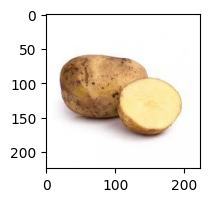

#Label : (90,)
#Un Label : (215,)
Processing class: Blackleg


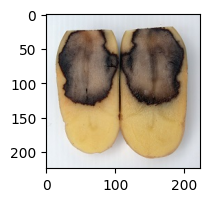

#Label : (20,)
#Un Label : (40,)
Processing class: Black Scurf


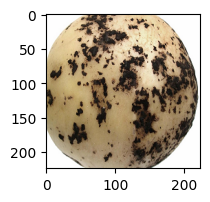

#Label : (20,)
#Un Label : (38,)
Processing class: Pink Rot


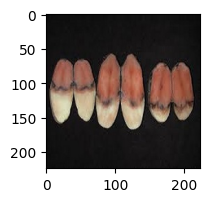

#Label : (20,)
#Un Label : (37,)
Processing class: Common Scab


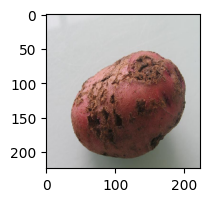

#Label : (20,)
#Un Label : (42,)
Processing class: Dry Rot


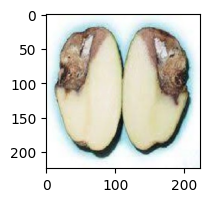

#Label : (20,)
#Un Label : (40,)
Labeled data shape: (190, 224, 224, 3) (190,)
Unlabeled data shape: (412, 224, 224, 3) (412,)


In [28]:
import numpy as np
import os
import tensorflow as tf
from sklearn.utils import shuffle

allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

def process_dataset_with_split(folder_path, class_name, num_labeled=20):
    print(f'Processing class: {class_name}')
    x_labeled, y_labeled, z_labeled = [], [], []
    x_unlabeled, y_unlabeled, z_unlabeled = [], [], []

    # Collect files and shuffle
    file_paths = [os.path.join(folder_path, class_name, filename) for filename in os.listdir(os.path.join(folder_path, class_name))
                  if filename.endswith(allowed_extensions)]
    file_paths = shuffle(file_paths, random_state=42)  # Use random_state for consistency

    # Split data
    labeled_files = file_paths[:num_labeled]
    unlabeled_files = file_paths[num_labeled:]

    # Load images and assign to labeled or unlabeled
    for file_path in labeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_labeled.append(img_array)
        y_labeled.append(class_mapping[class_name])

    for file_path in unlabeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_unlabeled.append(img_array)
        y_unlabeled.append(class_mapping[class_name])

    return (np.array(x_labeled), np.array(y_labeled)), (np.array(x_unlabeled), np.array(y_unlabeled))

# Example usage for loading and splitting data
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x_labeled, y_labeled, x_unlabeled, y_unlabeled = [], [], [], []

for class_name in class_mapping.keys():
    if class_name == 'Healthy':
        num_labeled = 90
    else:
        num_labeled = 20
    (x_l, y_l), (x_u, y_u) = process_dataset_with_split(folder_path, class_name,  num_labeled)
    plt.figure(figsize = (2,2))
    plt.imshow(x_l[0])
    plt.show()
    print('#Label :', y_l.shape)
    print('#Un Label :', y_u.shape)
    print('====================================================')

    x_labeled.append(x_l)
    y_labeled.append(y_l)
    x_unlabeled.append(x_u)
    y_unlabeled.append(y_u)

# Concatenate arrays from all classes
x_labeled = np.concatenate(x_labeled, axis=0)
y_labeled = np.concatenate(y_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
y_unlabeled = np.concatenate(y_unlabeled, axis=0)

print('Labeled data shape:', x_labeled.shape, y_labeled.shape)
print('Unlabeled data shape:', x_unlabeled.shape, y_unlabeled.shape)


# X similarity_cosine X

Processing class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

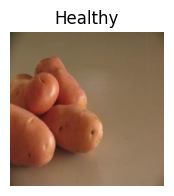

# Labeled: (90,)
# Unlabeled: (215,)
Processing class: Blackleg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

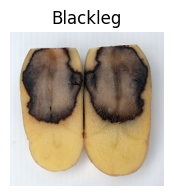

# Labeled: (20,)
# Unlabeled: (40,)
Processing class: Black Scurf
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━

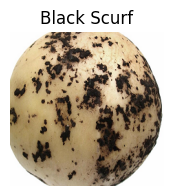

# Labeled: (20,)
# Unlabeled: (38,)
Processing class: Pink Rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

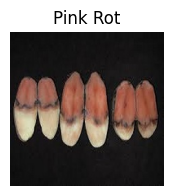

# Labeled: (20,)
# Unlabeled: (37,)
Processing class: Common Scab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━

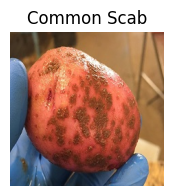

# Labeled: (20,)
# Unlabeled: (42,)
Processing class: Dry Rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

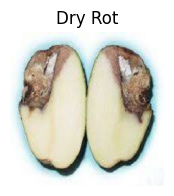

# Labeled: (20,)
# Unlabeled: (40,)
Labeled data shape: (190, 4096) (190,)
Unlabeled data shape: (412, 4096) (412,)
Cosine similarity between first two labeled images: 0.7556
Euclidean similarity between first two labeled images: 0.0209


In [20]:
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define allowed image extensions and class mapping
allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

# Load VGG16 model with ImageNet weights
def get_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=True)
    feature_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
    return feature_model

feature_model = get_vgg16_model()

def process_dataset_with_split(folder_path, class_name, num_labeled=20):
    print(f'Processing class: {class_name}')
    x_labeled, y_labeled = [], []
    x_unlabeled, y_unlabeled = [], []

    # Collect files and shuffle
    class_folder_path = os.path.join(folder_path, class_name)
    file_paths = [os.path.join(class_folder_path, filename) for filename in os.listdir(class_folder_path)
                  if filename.lower().endswith(allowed_extensions)]
    np.random.shuffle(file_paths)  # Use numpy for in-place shuffling

    # Split data
    labeled_files = file_paths[:num_labeled]
    unlabeled_files = file_paths[num_labeled:]

    # Load images and assign to labeled or unlabeled
    for file_path in labeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature_vector = feature_model.predict(img_array)
        x_labeled.append(feature_vector.flatten())
        y_labeled.append(class_mapping[class_name])

    for file_path in unlabeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature_vector = feature_model.predict(img_array)
        x_unlabeled.append(feature_vector.flatten())
        y_unlabeled.append(class_mapping[class_name])

    return (np.array(x_labeled), np.array(y_labeled)), (np.array(x_unlabeled), np.array(y_unlabeled))

def calculate_similarity_cosine(vector1, vector2):
    """Calculate cosine similarity between two vectors."""
    return cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]

def calculate_similarity_euclidean(vector1, vector2):
    """Calculate Euclidean similarity between two vectors."""
    return 1 / (1 + np.linalg.norm(vector1 - vector2))

# Example usage for loading and splitting data
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x_labeled, y_labeled, x_unlabeled, y_unlabeled = [], [], [], []

for class_name in class_mapping.keys():
    num_labeled = 90 if class_name == 'Healthy' else 20
    (x_l, y_l), (x_u, y_u) = process_dataset_with_split(folder_path, class_name, num_labeled)

    # Display a sample image
    sample_img_path = os.path.join(folder_path, class_name, os.listdir(os.path.join(folder_path, class_name))[0])
    img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=(224, 224))
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
    plt.show()

    print(f'# Labeled: {y_l.shape}')
    print(f'# Unlabeled: {y_u.shape}')
    print('====================================================')

    x_labeled.append(x_l)
    y_labeled.append(y_l)
    x_unlabeled.append(x_u)
    y_unlabeled.append(y_u)

# Concatenate arrays from all classes
x_labeled = np.concatenate(x_labeled, axis=0)
y_labeled = np.concatenate(y_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
y_unlabeled = np.concatenate(y_unlabeled, axis=0)

print('Labeled data shape:', x_labeled.shape, y_labeled.shape)
print('Unlabeled data shape:', x_unlabeled.shape, y_unlabeled.shape)

# Example similarity calculation between two images
if x_labeled.shape[0] > 1:
    similarity_cosine = calculate_similarity_cosine(x_labeled[0], x_labeled[1])
    similarity_euclidean = calculate_similarity_euclidean(x_labeled[0], x_labeled[1])

    print(f'Cosine similarity between first two labeled images: {similarity_cosine:.4f}')
    print(f'Euclidean similarity between first two labeled images: {similarity_euclidean:.4f}')


# X Not use X

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Assume x_labeled and y_labeled are already defined and contain image data and labels respectively

# Preprocess images
def preprocess_images(images):
    return preprocess_input(images)

# Build the VGG16 model with global max pooling
def build_feature_extractor():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers except the last three
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    # Add Global Max Pooling layer
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Extract features from images
def extract_features(images, model):
    return model.predict(images)

# Calculate similarity
def calculate_similarity(features):
    return cosine_similarity(features)

# Find most similar images
def find_most_similar_images(similarities, top_n=5):
    most_similar_indices = np.argsort(-similarities, axis=1)[:, 1:top_n+1]  # Exclude self-similarity
    return most_similar_indices

# Display similar images
def display_similar_images(images, indices, num_images=5):
    for i in range(len(images)):
        plt.figure(figsize=(15, 3))
        plt.subplot(1, num_images + 1, 1)
        plt.imshow(images[i])  # Display image directly
        plt.title('Query')
        plt.axis('off')

        for j in range(num_images):
            plt.subplot(1, num_images + 1, j + 2)
            plt.imshow(images[indices[i][j]])  # Display similar images
            plt.title(f'Rank {j+1}')
            plt.axis('off')

        plt.show()

# Ensure x_labeled is resized to (224, 224, 3)
x_labeled_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_labeled])

# Preprocess images
images = preprocess_images(x_labeled_resized)

# Build and compile feature extractor model
feature_extractor = build_feature_extractor()

# Extract features
features = extract_features(images, feature_extractor)

# Calculate similarities
similarities = calculate_similarity(features)

# Find the most similar images
most_similar_indices = find_most_similar_images(similarities, top_n=5)

# Convert images for display
images_for_display = [tf.keras.preprocessing.image.array_to_img(img) for img in x_labeled_resized]

# Display results
display_similar_images(images_for_display, most_similar_indices, num_images=5)


Output hidden; open in https://colab.research.google.com to view.

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Define class mapping
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Preprocess images
def preprocess_images(images):
    return preprocess_input(images)

# Build the VGG16 model with global max pooling
def build_feature_extractor():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers except the last three
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    # Add Global Max Pooling layer
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Extract features from images
def extract_features(images, model):
    return model.predict(images)

# Calculate similarity
def calculate_similarity(features):
    return cosine_similarity(features)

# Find most similar images
def find_most_similar_images(similarities, top_n=5):
    most_similar_indices = np.argsort(-similarities, axis=1)[:, 1:top_n+1]  # Exclude self-similarity
    return most_similar_indices

# Predict class based on similarity
def predict_class(similarities, class_labels):
    predicted_classes = []
    for i in range(similarities.shape[0]):
        top_indices = np.argsort(-similarities[i])[:1]  # Get the index of the most similar image
        predicted_classes.append(class_labels[top_indices[0]])
    return predicted_classes

# Display similar images
def display_similar_images(images, indices, predicted_classes, num_images=5):
    for i in range(len(images)):
        plt.figure(figsize=(15, 3))
        plt.subplot(1, num_images + 1, 1)
        plt.imshow(images[i])  # Display image directly
        plt.title(f'Query: {reverse_class_mapping[y_labeled[i]]}')
        plt.axis('off')

        for j in range(num_images):
            plt.subplot(1, num_images + 1, j + 2)
            plt.imshow(images[indices[i][j]])  # Display similar images
            plt.title(f'Rank {j+1}: {reverse_class_mapping[predicted_classes[i]]}')
            plt.axis('off')

        plt.show()

# Ensure x_labeled is resized to (224, 224, 3)
x_labeled_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_labeled])

# Preprocess images
images = preprocess_images(x_labeled_resized)

# Build and compile feature extractor model
feature_extractor = build_feature_extractor()

# Extract features
features = extract_features(images, feature_extractor)

# Calculate similarities
similarities = calculate_similarity(features)

# Find the most similar images
most_similar_indices = find_most_similar_images(similarities, top_n=5)

# Predict class for each image based on most similar images
predicted_classes = predict_class(similarities, y_labeled)

# Convert images for display
images_for_display = [tf.keras.preprocessing.image.array_to_img(img) for img in x_labeled_resized]

# Display results
display_similar_images(images_for_display, most_similar_indices, predicted_classes, num_images=5)


Output hidden; open in https://colab.research.google.com to view.

# Use this

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Define class mapping
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Preprocess images
def preprocess_images(images):
    return preprocess_input(images)

# Build the VGG16 model with global max pooling
def build_feature_extractor():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers except the last three
    for layer in base_model.layers[:-3]:
        layer.trainable = False

    # Add Global Max Pooling layer
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Extract features from images
def extract_features(images, model):
    return model.predict(images)

# Calculate similarity
def calculate_similarity(features):
    return cosine_similarity(features)

# Find most similar images
def find_most_similar_images(similarities, top_n=5):
    most_similar_indices = np.argsort(-similarities, axis=1)[:, 1:top_n+1]  # Exclude self-similarity
    return most_similar_indices

# Predict class based on similarity
def predict_class(similarities, class_labels):
    predicted_classes = []
    for i in range(similarities.shape[0]):
        top_indices = np.argsort(-similarities[i])[:1]  # Get the index of the most similar image
        predicted_classes.append(class_labels[top_indices[0]])
    return predicted_classes

# Display similar images with similarity scores
def display_similar_images(images, indices, predicted_classes, similarities, num_images=5):
    for i in range(len(images)):
        plt.figure(figsize=(15, 3))
        plt.subplot(1, num_images + 1, 1)
        plt.imshow(images[i])  # Display image directly
        plt.title(f'Query: {reverse_class_mapping[y_labeled[i]]}')
        plt.axis('off')

        for j in range(num_images):
            plt.subplot(1, num_images + 1, j + 2)
            plt.imshow(images[indices[i][j]])  # Display similar images
            plt.title(f'Rank {j+1}\n{reverse_class_mapping[predicted_classes[i]]}\nScore: {similarities[i][indices[i][j]]:.2f}')
            plt.axis('off')

        plt.show()

# Ensure x_labeled is resized to (224, 224, 3)
x_labeled_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_labeled])

# Preprocess images
images = preprocess_images(x_labeled_resized)

# Build and compile feature extractor model
feature_extractor = build_feature_extractor()

# Extract features
features = extract_features(images, feature_extractor)

# Calculate similarities
similarities = calculate_similarity(features)

# Find the most similar images
most_similar_indices = find_most_similar_images(similarities, top_n=5)

# Predict class for each image based on most similar images
predicted_classes = predict_class(similarities, y_labeled)

# Convert images for display
images_for_display = [tf.keras.preprocessing.image.array_to_img(img) for img in x_labeled_resized]

# Display results
display_similar_images(images_for_display, most_similar_indices, predicted_classes, similarities, num_images=5)

Output hidden; open in https://colab.research.google.com to view.